In [1]:
import numpy as np
import matplotlib.pyplot as plt
import inspect

import qiskit
from qiskit import Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, execute
from qiskit.test.mock import *
from qiskit.circuit import Parameter
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization import QuadraticProgram

from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.transpiler import Target, InstructionProperties
from qiskit import IBMQ

from qiskit.converters import circuit_to_dag
from inspect import getmembers, isclass
from qiskit.tools.jupyter import *   #call the name of the fake backend to get an overview of all properties as inline window
from qiskit.tools.visualization import circuit_visualization, circuit_drawer, matplotlib, plot_gate_map
from qiskit.transpiler import CouplingMap
from qiskit.visualization import plot_coupling_map
from qiskit.transpiler.exceptions import CouplingError
from qiskit.exceptions import MissingOptionalLibraryError

import pytket
from pytket import Circuit, OpType
from pytket.extensions.qiskit import (
    AerStateBackend,
    AerBackend,
    AerUnitaryBackend,
    IBMQBackend,
    IBMQEmulatorBackend,
)
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit

from pytket.extensions.qiskit.tket_backend import TketBackend
from pytket.circuit.display import render_circuit_jupyter
from pytket.utils import Graph
from pytket.backends import Backend

from pytket.predicates import Predicate, GateSetPredicate, NoClassicalBitsPredicate, NoSymbolsPredicate, NoClassicalControlPredicate, NoMidMeasurePredicate, NoFastFeedforwardPredicate
from pytket.passes import (
    BasePass,
    SequencePass,
    DecomposeBoxes,
    SynthesiseTket,
    FullPeepholeOptimise,
    RebaseCustom,
    SquashCustom,
    NaivePlacementPass, RemoveRedundancies, SimplifyInitial, CliffordSimp, CXMappingPass, auto_rebase_pass
)
from pytket.placement import NoiseAwarePlacement
from typing import List
import ast
from pytket.backends.backendinfo import BackendInfo
from pytket.architecture import FullyConnected
from pytket.backends import ResultHandle, CircuitStatus, StatusEnum, CircuitNotRunError
from pytket.backends.resulthandle import _ResultIdTuple
from pytket.backends.backendresult import BackendResult
from pytket.utils.results import KwargTypes
from typing import Iterable, Optional
from uuid import uuid4
from pytket.architecture import Architecture

import networkx as nx
import pydot
import io
import warnings
import itertools
from itertools import chain, combinations

In [2]:
import csv
import os
import sys
import collections
nb_dir = os.getcwd()
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from get_simple_circ_QAOA_from_qubo import *
from TopologyFunctions import *
from maxcut import *
from qaoa import *

### IBM-Q

3 different base topologies: Eagle (Washington), Hummingbird (Brooklyn), Falcon (Montreal).
Load the Hummingbird (65 qubits) and Falcon (28 qubits) topologies from FakeBackends and extend them or create new topology from scratch. <br>

- Extend topologies by using **get_extended_heavy_hex_IBMQ**
- For plotting nice coupling maps using the plot_coupling_map function, we need the qubit coordinates and a version of the coupling map containing every connection only once (i.e., only [0,1] and not [1,0]). This is achieved by the fuinctions **get_qubit_coordinates_heavy_hex** and **get_coupling_map_single_heavy_hex**

In [3]:
## for using IBM-Q account
#IBMQ.save_account('c3dc22e41088a5139a8f2b740aa1e61141b03d5537d656b8342d47899282dd79c7087dcf7f59d5748c228aa884205df6369725074d69685b0d150c7ce222b8d3')
#IBMQ.load_account() # if you already saved your API key on the device
#provider = IBMQ.get_provider(group='open', project='main')
#system = provider.get_backend('ibmq_belem')


#load Hummingbird and Falcon from Fake backends

#for member in getmembers(qiskit.test.mock.backends, isclass):
#    print(member[0])

IBM_Hummingbrid = FakeBrooklyn()
conn_IBM_Hummingbrid = [g.to_dict().get('qubits') for g in IBM_Hummingbrid.properties().gates if len(g.to_dict().get('qubits'))>1]
#print(conn_IBM_Hummingbrid)
cmap_IBM_Hummingbrid = CouplingMap(conn_IBM_Hummingbrid)
#plot_gate_map(IBM_Hummingbrid)

IBM_Falcon = FakeMontreal()
conn_IBM_Falcon = [g.to_dict().get('qubits') for g in IBM_Falcon.properties().gates if len(g.to_dict().get('qubits'))>1]
#print(conn_IBM_Falcon)
cmap_IBM_Falcon = CouplingMap(conn_IBM_Falcon)

Extend Hummingbrid to Washington: Add 2 extra rows and 1 extra column. <br>
If the real Washinton topology is needed, the function remove_conn_IBMQ_Washington removes two connection which are missing in the real device. 

In [4]:
extra_rows=2
extra_columns=1
conn_IBM_Washington, n_qubits_new, n_rows, n_cells_per_row = get_extended_heavy_hex_IBMQ(conn_IBM_Hummingbrid, extra_rows, extra_columns)
conn_IBM_Washington_original = remove_conn_IBMQ_Washington(conn_IBM_Washington)

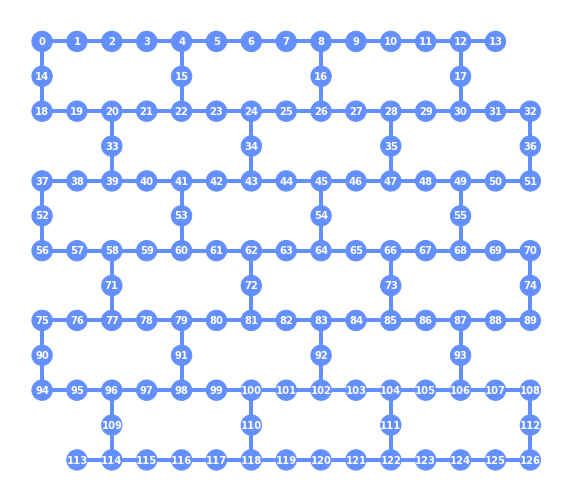

In [5]:
# for plotting: 
cmap_plot=get_coupling_map_single_heavy_hex(conn_IBM_Washington)
qubit_coordinates=get_qubit_coordinates_heavy_hex(6, 3, 1)
plot_coupling_map(len(get_qubits_for_coupling_map(conn_IBM_Washington)), qubit_coordinates, cmap_plot, figsize=(10,10))

Create Topology like IBM-Q Washington from scratch

In [11]:
n_rows = 8
n_cols = 3
conn_IBM_Wash_test = create_heavy_hex_IBMQ(n_rows, n_cols)

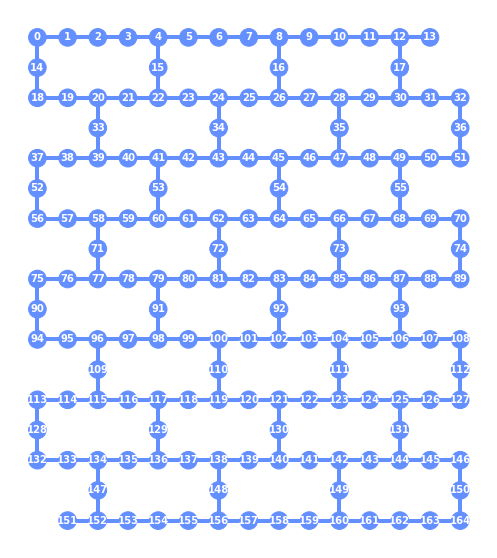

In [13]:
# for plotting: 
n_qubits_test = len(set(sum(conn_IBM_Wash_test, [])))
cmap_plot=get_coupling_map_single_heavy_hex(conn_IBM_Wash_test)
qubit_coordinates=get_qubit_coordinates_heavy_hex(n_rows, n_cols, 1)
plot_coupling_map(n_qubits_test, qubit_coordinates, cmap_plot, figsize=(10,10))

Connectivity: Analyze coupling density and nearest neigbours. <br>
Increase connectivity by randomly adding connections

In [26]:
print(get_coupling_density(conn_IBM_Wash_test))
print(get_num_NN(conn_IBM_Wash_test))

0.013895048041389505
2.278787878787879


In [42]:
conn_IBM_Wash_extended = increase_coupling_density(conn_IBM_Wash_test, 0.1)
print(get_coupling_density(conn_IBM_Wash_extended))
print(get_num_NN(conn_IBM_Wash_extended))

0.1
16.4


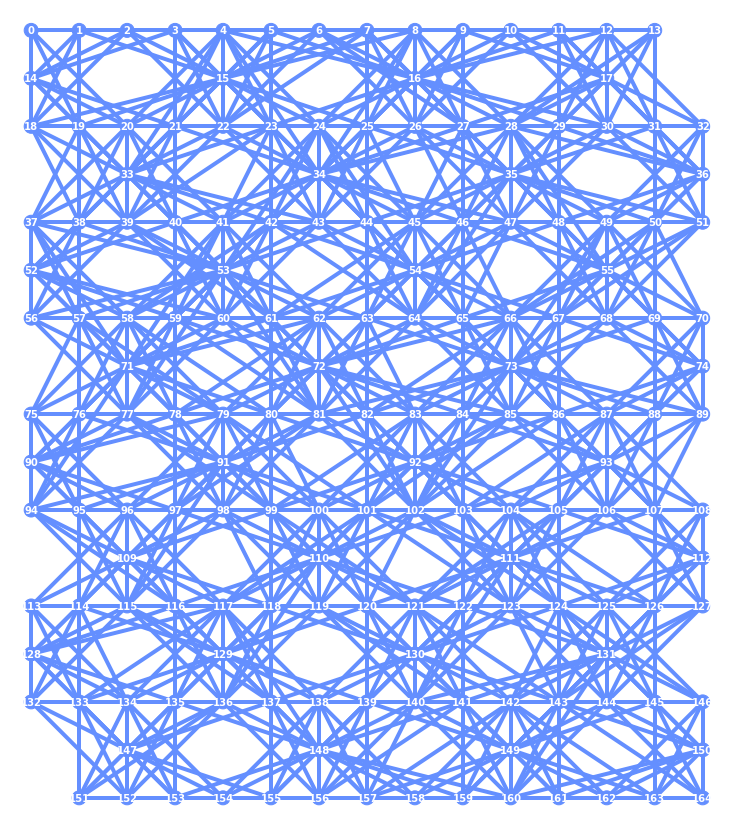

In [31]:
cmap_single = get_coupling_map_single_heavy_hex(conn_IBM_Wash_extended)
qubit_coordinates=get_qubit_coordinates_heavy_hex(n_rows, n_cols, 2)
plot_coupling_map(len(set(sum(conn_IBM_Wash_extended, []))), qubit_coordinates, cmap_single, figsize=(15,15))
